In [1]:
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import os
import json
from datetime import datetime
import multiprocessing as mp
import glob

In [2]:
import models.graphene_thermodynamics_v2 as gt
from models.cooling_phonons_v3 import CoolingPhonons
from models.graphene_optics import GrapheneTHG

In [3]:
# Load interpolation data for the calculation of chemical potentials.
mm = gt.mu_func_use_2d_interpolation(load_from="mu_table.pkl")

In [4]:
run_label = "test_pe_relax"
time_stamp = datetime.now().strftime("%Y-%m-%d-%H-%M-%S")
saveDir = "./data/02/%s_%s" % (time_stamp, run_label)
os.mkdir(saveDir)

In [5]:
# saveDir = "2023-04-28-21-49-03_debug"

In [6]:
# One time-evolution with pump and probe pulse.
def oneRun(x):
    dyn = CoolingPhonons(**x["sysparams"])
    tmax = x["sysparams"]["pr_delay"] + x["sysparams"]["pr_dt"] * 2.0
    runparams = {
        # Integrate up to a bit later than the end of the probe pulse.
        "tmax": tmax,
        "tnum": int(300 * tmax / 1.0e+4),  # proportional to 300 points for 10ps
        "dt_approx": 5.0,
        "print_time": False    
    }
    dyn.run(**runparams)

    with open("%s/params-%02d.json" % (x["saveDir"], x["il"]), "w") as f:
        json.dump({"sysparams": x["sysparams"], "runparams": runparams}, f, indent=4)

    np.savetxt("%s/dynamics-%02d.csv" % (x["saveDir"], x["il"]), dyn.dynamics_m, delimiter=",")
    np.savetxt("%s/thg-%02d.csv" % (x["saveDir"], x["il"]), np.c_[dyn.p["pr_tt"],dyn.p["etaTHG"]], delimiter=",")
    
    r = (x["sysparams"]["pr_delay"], dyn.p["etaTHG_avg"], dyn.p["etaTHG_max"])
    np.savetxt("%s/thg_avg-%02d.csv" % (x["saveDir"], x["il"]), np.array(r), delimiter=",")
    return r

In [192]:
# Generate a list of parameters to parallelize the calculation.
sysparams = {
    "eF": 0.300,
    "tempK_eq": 30.0,
    "tau_ph": 1200.0,
    "pu_fluenceSI": 170.0,  # ORIG: 200.0  or 170.0
    "pu_dt": 110.0,
    "pu_eph": 1.200,
    "pr_fluenceSI": 110.0,  # ORIG: 110.0
    "pr_dt": 150.0,
    "pr_eph": 0.320,
    "nsub": 1.4,  # hBN encapsulated with SiO2 around
    "ntop": 1.4,
    "alpha_res": 1.0e-5,  # ORIG: 1.0e-3
    "gammaConst": 0.0,
    "gammaProp": 0.50,  # 0.55
    "gammaInv": 0.02,
    "dtdb": 45.0,  # ORIG: 200.0
    "ph_en_frac": 1.0,
    "dtdb_cutoff_dens": None,
    "pe_relax_rate": 1.0/100.0
}


# List of delay values.
pr_delay_list = np.linspace(0.0, 5.0e+3, 31)
pr_delay_list = np.logspace(np.log10(50.0), np.log10(5000.0), 31)
#pr_delay_list = np.linspace(200.0, 1.0e+3, 31)
np.savetxt("%s/delays.csv" % saveDir, pr_delay_list, delimiter=",")
# Add the value of the delay, taken from the list, to the dictionary of sysparams.
params_list = [{"il": il, "saveDir": saveDir, "sysparams": {**sysparams, "pr_delay": pr_delay}} for il,pr_delay in enumerate(pr_delay_list)]

In [193]:
# Run the calculation and save the results.
with mp.Pool(24) as p:
    thg_list = p.map(oneRun, params_list)

thg_list = np.array(thg_list)
np.savetxt("%s/thg_vs_delay.csv" % saveDir, thg_list, delimiter=",")

In [194]:
# Calculate the THG without the pump pulse, i.e. with negligible intensity.
# This will be the reference value of the THG.
sysparams0 = sysparams.copy()
sysparams0["pu_fluenceSI"] = 0.0
sysparams0["pr_delay"] = pr_delay_list[0]

dyn0 = CoolingPhonons(**sysparams0)
tmax = sysparams0["pr_delay"] + sysparams0["pr_dt"] * 2.0
runparams0 = {
    # Integrate up to a bit later than the end of the probe pulse.
    "tmax": tmax,
    "tnum": int(300 * tmax / 1.0e+4),  # proportional to 300 points for 10ps
    "dt_approx": 5.0,
    "print_time": False    
}
dyn0.run(**runparams0)
thg0_avg = dyn0.p["etaTHG_avg"]
thg0_max = dyn0.p["etaTHG_max"]
# Save the result.
np.savetxt("%s/thg0_time.csv" % saveDir, np.c_[dyn0.p["pr_tt"],dyn0.p["etaTHG"]], delimiter=",")
np.savetxt("%s/thg0_pulse.csv" % saveDir, np.array([sysparams0["pr_delay"],thg0_avg, thg0_max]), delimiter=",")

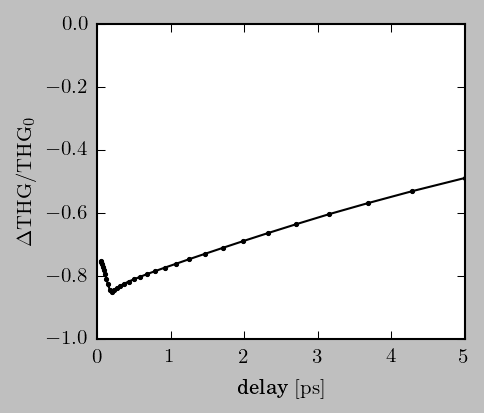

In [195]:
# Plot average and maximum THG during the probe pulse
# as a function of pump-probe delay.
mpl.style.use(["classic", "latex"])
plt.figure(figsize=(3.5,3.0), frameon=True, dpi=150)
plt.axes([0.2, 0.2, 0.7, 0.7])
plt.plot(thg_list[:,0] * 1.0e-3, (thg_list[:,1] - thg0_avg) / thg0_avg, "-ok", ms=2.0)
#plt.plot(thg_list[:,0] * 1.0e-3, (thg_list[:,2] - thg0_max) / thg0_max, "or", ms=2.0, mew=0.0)
#plt.xlim([0.0, 1.0])
plt.ylim([-1.0, 0.0])
plt.xlabel(r"delay $[{\rm ps}]$")
# plt.ylabel(r"$\eta_{\rm THG}$")
plt.ylabel(r"$\Delta{\rm THG}/{\rm THG}_{0}$")
plt.savefig("%s/plot_etaTHG_delay.png" % saveDir, dpi=300)

In [11]:
# Load all the time-dependent THGs to test other ways to average.
delays = np.loadtxt("%s/delays.csv" % saveDir, delimiter=",")
thg_delay = [np.loadtxt("%s/thg-%02d.csv" % (saveDir, i), delimiter=",") for i in range(len(delays))]
thg_delay.append(np.loadtxt("%s/thg0_time.csv" % saveDir, delimiter=","))

In [12]:
# Several transformation of the signal.
from scipy.integrate import simps
# Average and maximum (above) are special cases.
# trasf_delay = [s[-1,1] for s in thg_delay]  # last value of the THG
trasf_delay = [s[:,1].min() for s in thg_delay]  # minimum value of the THG
# trasf_delay = [simps(s[:-3,1], s[:-3,0]) for s in thg_delay]  # average only some points

In [13]:
# Differential transformed signal.
diff_signal = [(trasf-trasf_delay[-1])/trasf_delay[-1] for trasf in trasf_delay[:-1]]

Text(0, 0.5, '$\\Delta{\\rm THG}/{\\rm THG}_{0}$')

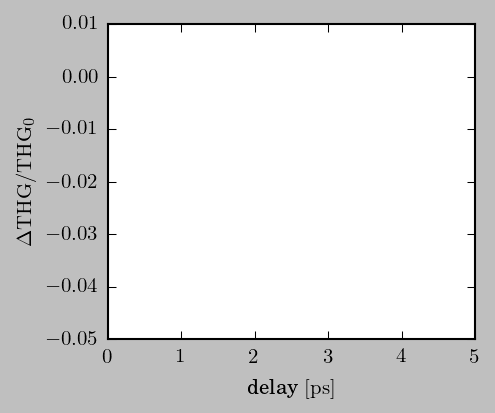

In [14]:
# Plot average and maximum THG during the probe pulse
# as a function of pump-probe delay.
mpl.style.use(["classic", "latex"])
plt.figure(figsize=(3.5,3.0), frameon=True, dpi=150)
plt.axes([0.2, 0.2, 0.7, 0.7])
plt.plot(delays * 1.0e-3, diff_signal, "ok", ms=3.0)
#plt.xlim([0.0, 1.0])
plt.ylim([-0.05, 0.01])
plt.xlabel(r"delay $[{\rm ps}]$")
# plt.ylabel(r"$\eta_{\rm THG}$")
plt.ylabel(r"$\Delta{\rm THG}/{\rm THG}_{0}$")
# plt.savefig("%s/plot_etaTHG_delay.png" % saveDir, dpi=300)